# Introduction

In my analysis, I will be exploring the following:

- Based on the reviews of the last year, what makes a good user experience at a Airbnb rental? What makes a poor user experience? What would you advise to new Airbnb hosts to ensure high reviews and consistent renters?
- What are some of the seasonal Airbnb trends you've noticed in the San Francisco area? When are the down months over the last year? Which months are the most busy? Which areas were the most popular during these times? How have prices changed over time?
- Are airbnb's that are available for monthly rent competitive with the local markets?
- Can you create a price predictor for listings price? What features allows renters to charge more?

In [2]:
#Read in libraries
import dask.dataframe as dd
import swifter

import pandas as pd
import pandas_profiling

import re

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#Set pandas backend to create interactive plots
#pd.options.plotting.backend = 'hvplot'

#Whats the defailt back end? Not all plots work with this

In [5]:
#Set plot aesthetics for notebook
sns.set(style='whitegrid', palette='pastel', color_codes=True)

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#Set float format
pd.options.display.float_format = '{:.0f}'.format

#Ignore warnings
import warnings; warnings.simplefilter('ignore')

**Read in Data**

In [6]:
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate/'

In [7]:
#Read in Zillow data
zillow = pd.read_csv(path + '12_29_2019_Zillow_Cleaned.csv', index_col=0, sep=',')

#Read in Airbnb Listings Data
listings = pd.read_csv(path + '12_27_2019_Listings_Cleaned.csv',index_col=0, low_memory=False, sep=',')

#Parse dates
parse_dates = ['date']

#Read in Airbnb Calendar and Reviews data
calendar = pd.read_csv(path + '12_23_2019_Calendar_Cleaned.csv', sep = ',',
                       parse_dates=parse_dates, low_memory=False,index_col=0)

reviews = pd.read_csv(path + '12_24_2019_Reviews_Cleaned.csv', sep=',',
                      parse_dates=parse_dates,index_col=0)

# Data Preview

**Airbnb Listings Data**

In [8]:
#Preview listings data
display(listings.head().T)

,0,1,2,3,5
accommodates,3,5,2,2,6
amenities,TV Cable TV Internet Wifi Kitchen Pets liv...,Internet Wifi Kitchen Heating Family/kid fri...,TV Internet Wifi Kitchen Free street parking...,TV Internet Wifi Kitchen Free street parking...,TV Cable TV Internet Wifi Kitchen Free par...
availability_30,0,0,30,30,0
availability_365,77,0,365,365,20
bathrooms,1,1,4,4,1
bed_type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed
bedrooms,1,2,1,1,2
beds,2,3,1,1,3
calculated_host_listings_count,1,1,9,9,1
calculated_host_listings_count_private_rooms,0,0,9,9,0


**Airbnb Reviews Data**

In [9]:
#Preview reviews data
display(reviews.head())

,comments,date,id,listing_id,reviewer_id,reviewer_name
19330,...,2013-12-01,9000494,209514,9215434,Ramon
143113,Stop and book it now Rea Website hidd...,2017-06-07,158659946,4833101,35954713,Tim
1021372,So I moved to SF in late May from Mich...,2013-06-02,4928809,635850,6542011,Michael
64636,This was the perfect home from home ou...,2014-10-16,21374058,1150867,13431837,Chris & Tess
174143,We loved our time in beautiful SF The p...,2018-08-10,305042501,7226841,73281468,Jessica ( + Mark)


**Airbnb Calendar Data**

In [10]:
#Preview calendar data
display(calendar.head())

,adjusted_price,available,date,listing_id,maximum_nights,minimum_nights,price
0,80,0,2019-04-03,187730,120,3,80
1,80,0,2019-04-04,187730,120,3,80
2,82,1,2019-04-05,187730,120,3,82
3,82,1,2019-04-06,187730,120,3,82
4,81,1,2019-04-07,187730,120,3,81


**Zillow Data**

In [11]:
#Preview zillow data
display(zillow.head())

,City,County,Metro,Zip,State,SizeRank,Bedrooms,Date,Median_Rent
4928,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-03-01,1200
11368,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-04-01,1250
17808,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-05-01,1200
24248,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-06-01,1250
30688,Virginia Beach,Virginia Beach City,Virginia Beach-Norfolk-Newport News,23462,VA,83,3,2010-07-01,1225


# Data Exploration

- How has Airbnb grown over the last year? Which neighborhoods have shown the most growth?
- What are the metrics for the different neighborhoods in SF?
- Are airbnb's that are available for monthly rent competitive with the local rent market? Is Airbnb a legitmate option to consider for short term living as opposed to finding month to month leases?
- What are the different data distributions for the different outcome variables we are interested in exploring?



#### What are the different data distributions for the different outcome variables we are interested in exploring?


date

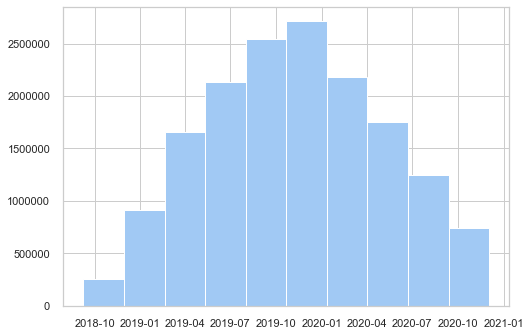

In [12]:
calendar.date.hist()

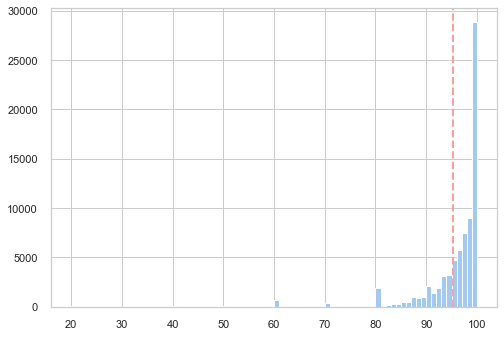

In [13]:
#plot hist
listings.review_scores_rating.hist(bins = 80)

#plot the mean
mean = np.mean(listings.review_scores_rating)

plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

Listings price

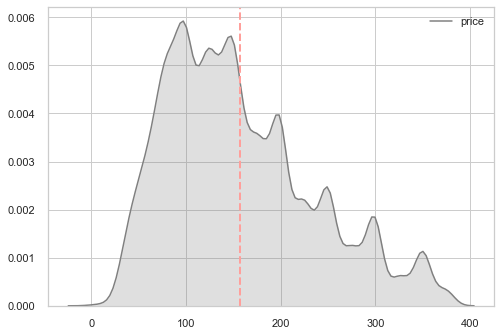

In [14]:

#KDE
ax = sns.kdeplot(listings.price, shade=True, color="grey")
#plot the mean
mean = np.mean(listings.price)

plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

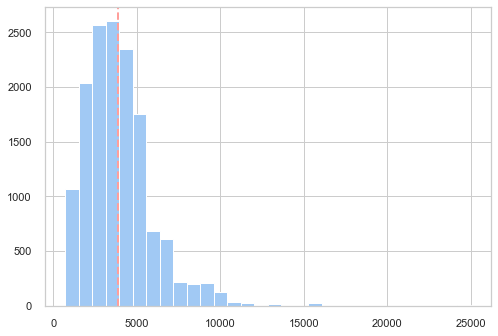

In [15]:
listings.monthly_price.hist(bins = 30)

#plot the mean
mean = np.mean(listings.monthly_price)

plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

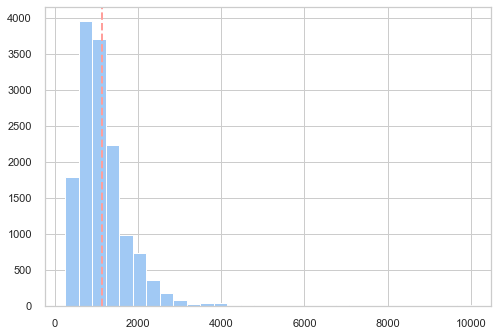

In [16]:
listings.weekly_price.hist(bins = 30)

#plot the mean
mean = np.mean(listings.weekly_price)

plt.axvline(mean, color='r', linewidth=2, linestyle='--', label= str(round(mean,2)))

#### How has Airbnb grown over the last year(11/2018 - 10/2019)?

Let's begin by taking a look at the number of unique listings per month available for rent from Airbnb hosts.

## Comeback to this

should date be set as the index? How wouls the time series plot look if you had the raw data, a monthly rolling average?

In [17]:
#Convert date to month year and add to calendar
#calendar['month_year'] = pd.to_datetime(calendar['date']).dt.to_period('M') #would this work in time series?
calendar.set_index('date', inplace=True)

#Extract date info from index
calendar['year'] = calendar.index.year
calendar['month'] = calendar.index.month
calendar['weekday'] = calendar.index.weekday_name

calendar.head()

,adjusted_price,available,listing_id,maximum_nights,minimum_nights,price,year,month,weekday
date,,,,,,,,,
2019-04-03,80,0,187730,120,3,80,2019,4,Wednesday
2019-04-04,80,0,187730,120,3,80,2019,4,Thursday
2019-04-05,82,1,187730,120,3,82,2019,4,Friday
2019-04-06,82,1,187730,120,3,82,2019,4,Saturday
2019-04-07,81,1,187730,120,3,81,2019,4,Sunday


In [18]:
#Calendar data only through 2019 december
last_year = calendar.loc[(calendar.year < 2020)]

In [19]:
last_year.head()

,adjusted_price,available,listing_id,maximum_nights,minimum_nights,price,year,month,weekday
date,,,,,,,,,
2019-04-03,80,0,187730,120,3,80,2019,4,Wednesday
2019-04-04,80,0,187730,120,3,80,2019,4,Thursday
2019-04-05,82,1,187730,120,3,82,2019,4,Friday
2019-04-06,82,1,187730,120,3,82,2019,4,Saturday
2019-04-07,81,1,187730,120,3,81,2019,4,Sunday


In [20]:
#Group last year by month_year and get a count of unique listings per day
#last_year = 
last_year_daily = last_year.groupby(['date'])['listing_id'].agg({'nunique'}).reset_index()

In [21]:
# #Rename columns
last_year_daily =last_year_daily.rename(columns = {'nunique': 'listings'})

last_year_daily.head()

,date,listings
0,2018-09-08,794
1,2018-09-09,1136
2,2018-09-10,1095
3,2018-09-11,1025
4,2018-09-12,986


In [22]:
last_year_monthly = last_year.reset_index()
last_year_monthly.head()

,date,adjusted_price,available,listing_id,maximum_nights,minimum_nights,price,year,month,weekday
0,2019-04-03,80,0,187730,120,3,80,2019,4,Wednesday
1,2019-04-04,80,0,187730,120,3,80,2019,4,Thursday
2,2019-04-05,82,1,187730,120,3,82,2019,4,Friday
3,2019-04-06,82,1,187730,120,3,82,2019,4,Saturday
4,2019-04-07,81,1,187730,120,3,81,2019,4,Sunday


In [23]:
last_year_monthly['month_year'] = pd.to_datetime(last_year_monthly['date']).dt.to_period('M') #would this work in time series?
last_year_monthly = last_year_monthly.groupby('month_year')['listing_id'].agg({'nunique'}).reset_index()

# #Rename columns
last_year_monthly =last_year_monthly.rename(columns = {'nunique': 'listings'})

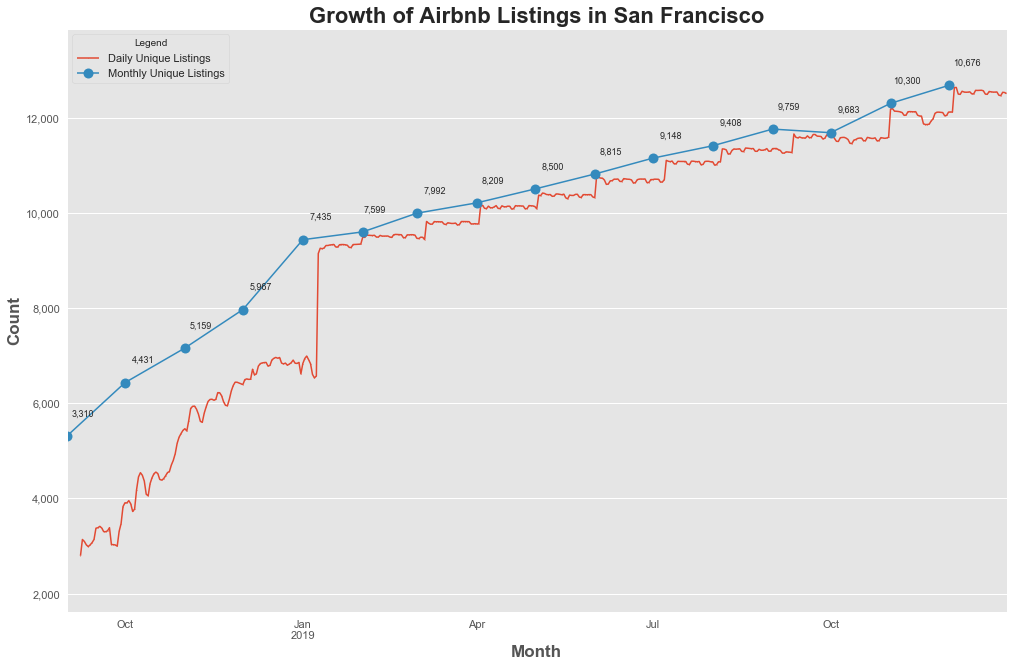

In [30]:
#Set 538 plot style
plt.style.use('fivethirtyeight')


#Plot daily unique listings data
ax = last_year_daily.plot(x='date', y='listings', kind = 'line',style='o-', markersize=.5,
          label= 'Daily Unique Listings',figsize = (15,10),
         linewidth = 1.5)
 

#plot weekly


#plot montly average
last_year_monthly.plot(x='month_year', y='listings',kind = 'line',style='o-', markersize= 10,
          label= 'Monthly Unique Listings',
         linewidth = 1.5 , ax=ax)

#Set fontdict
fontdict={'weight' : 'bold',
          'size': 17}

#Set x and y labels
ax.set_xlabel('Month',fontdict=fontdict)
ax.set_ylabel('Count', fontdict=fontdict)

#Format yticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

#Set Title
ax.set_title('Growth of Airbnb Listings in San Francisco', fontweight = 'bold', fontsize=22)

#Adjust plot margins
ax.margins(0,.12)

#Mute vertical grid lines
ax.grid(b = False, which ='major', axis = 'x')

#Add Text
xs,ys=last_year_monthly['month_year'], last_year_monthly['listings']

for x,y in zip(xs,ys):
    label = '{:,}'.format(y)
    plt.annotate(label, (x,y),textcoords="offset points",fontsize = 9, xytext=(-40,20), ha='center')

#Set legend
plt.legend(title='Legend', frameon = True, loc='upper left');

Over the last year, there has been significant growth in the number of listings available for rent month to month. Let us look into the number of nights booked by users over the last year.

**Growth by neighborhood September 2018 - December 2019**

We'll merge our calendar data with listings data to capture neighborhood data

In [25]:
#Convert calendar to dask to improve speed on merge
calendar_dd = dd.from_pandas(calendar, npartitions=3)


In [26]:
calendar_dd

,adjusted_price,available,listing_id,maximum_nights,minimum_nights,price,year,month,weekday
npartitions=3,,,,,,,,,
2018-09-08,float64,int64,int64,float64,float64,float64,int64,int64,object
2019-08-16,...,...,...,...,...,...,...,...,...
2020-01-31,...,...,...,...,...,...,...,...,...
2020-12-03,...,...,...,...,...,...,...,...,...


In [27]:
#capture listing id and neighbourhood_cleansed from listings for merge
neighborhoods = listings[['id', 'neighbourhood_cleansed']]

calendar_dd = calendar_dd.reset_index()

#Merge with calendar_dd
neighborhood_growth = calendar_dd.merge(neighborhoods, left_on ='listing_id', right_on='id')

#Drop redundant columnsa
neighborhood_growth= neighborhood_growth.drop(columns = ['id'])

In [28]:
neighborhood_growth

,date,adjusted_price,available,listing_id,maximum_nights,minimum_nights,price,year,month,weekday,neighbourhood_cleansed
npartitions=3,,,,,,,,,,,
,datetime64[ns],float64,int64,int64,float64,float64,float64,int64,int64,object,object
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [31]:
neighborhood_growth=neighborhood_growth[(neighborhood_growth['date'] < '2020-01-01')]

#convert to pandas
neighborhood_growth_pd = neighborhood_growth.compute()

#Group last year by month_year and get a count of unique listings per month
neighborhood_growth_pd = neighborhood_growth_pd.groupby(['neighbourhood_cleansed', 'year', 'month'])['listing_id'].agg({'nunique'}).reset_index()

#Rename columns
neighborhood_growth_pd =neighborhood_growth_pd.rename(columns = {'neighbourhood_cleansed': 'neighborhoods',
                                                                 'nunique': 'listings'})

In [32]:
neighborhood_growth_pd = neighborhood_growth_pd.sort_values(by=['year','month', 'listings'], ascending=False)

In [36]:
neighborhood_growth_pd.head()

,neighborhoods,year,month,listings
511,South of Market,2019,12,1027
111,Downtown/Civic Center,2019,12,944
271,Mission,2019,12,934
579,Western Addition,2019,12,793
31,Bernal Heights,2019,12,511


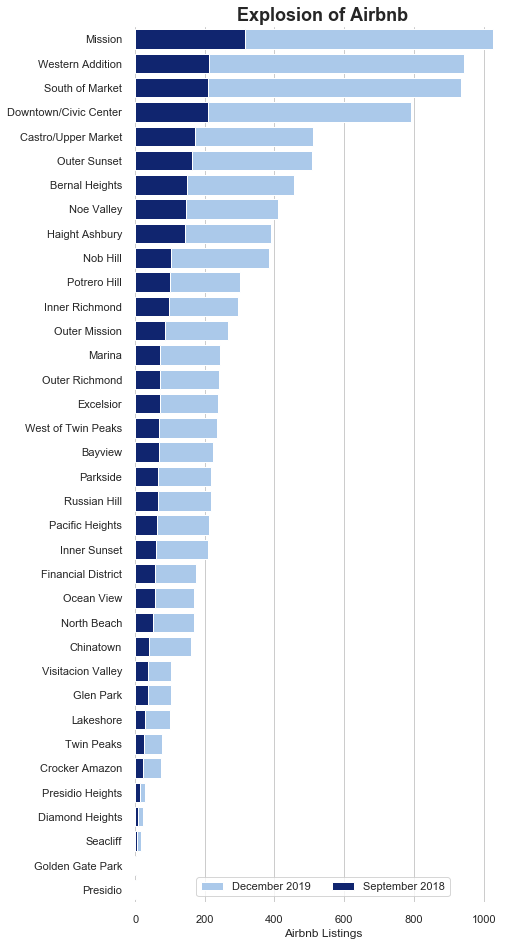

In [37]:
#Set fig size
f, ax = plt.subplots(figsize = (6,15))

#set style and color_pallete
sns.set(style='whitegrid')

#Set color codes for modern data
sns.set_color_codes('pastel')

#plot data from 
j = sns.barplot(x = 'listings', y = 'neighborhoods', color = 'b',
            data = neighborhood_growth_pd.loc[(neighborhood_growth_pd.month == 12 ) & 
                                         (neighborhood_growth_pd.year == 2019)],
                label = 'December 2019')

#Set color codes for older data
sns.set_color_codes('dark')

#Plot data from 2018-09
g = sns.barplot(x = 'listings', y = 'neighborhoods', color = 'b',
            data = neighborhood_growth_pd.loc[(neighborhood_growth_pd.month == 9 ) & 
                                         (neighborhood_growth_pd.year == 2018)],
                label = 'September 2018')

#Set legend info
ax.legend(frameon = True, ncol = 2, loc= 'lower center');

#Set Labels
ax.set(ylabel="", xlabel="Airbnb Listings")
ax.set_title('Explosion of Airbnb', fontweight = 'bold', fontsize = 18)


sns.despine(left=True, bottom=True)


In [38]:
last_year.head()

,adjusted_price,available,listing_id,maximum_nights,minimum_nights,price,year,month,weekday
date,,,,,,,,,
2019-04-03,80,0,187730,120,3,80,2019,4,Wednesday
2019-04-04,80,0,187730,120,3,80,2019,4,Thursday
2019-04-05,82,1,187730,120,3,82,2019,4,Friday
2019-04-06,82,1,187730,120,3,82,2019,4,Saturday
2019-04-07,81,1,187730,120,3,81,2019,4,Sunday


**Prices by property type**


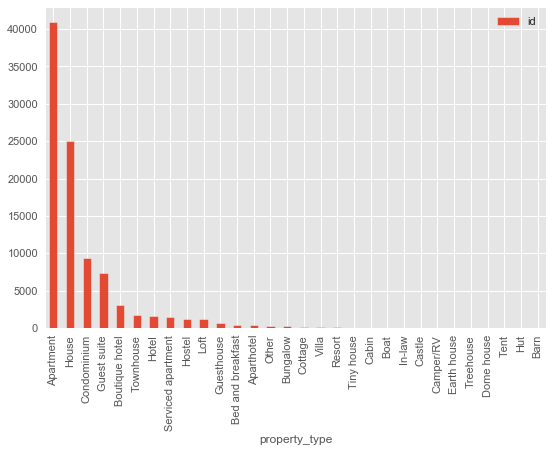

In [93]:
#Set 538 plot style
plt.style.use('ggplot')

#Counts of property types
prop_count = listings.groupby('property_type')['id'].count().sort_values(ascending = False).reset_index()
prop_count.plot(x = 'property_type', y = 'id', kind = 'bar')

In [109]:
#Get top 15 common prop types
prop_list=list(prop_count.property_type.head(15))

#sort top 15 by median value
test = listings[listings.property_type.isin(prop_list)].groupby('property_type')['price'].median().sort_values(ascending = False).reset_index()

In [110]:
test

,property_type,price
0,Boutique hotel,199
1,Loft,189
2,Hotel,180
3,Condominium,175
4,Serviced apartment,173
5,Other,149
6,Apartment,149
7,Townhouse,142
8,Guesthouse,140
9,Guest suite,140


In [113]:
test_list = test.property_type.tolist()

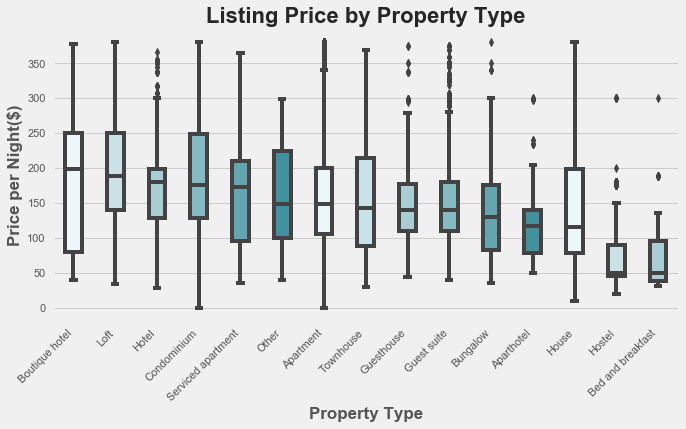

In [115]:
#Set 538 plot style
plt.style.use('fivethirtyeight')

#Set Figure
f, ax = plt.subplots(figsize= (10,5))

#Plot
g= sns.boxplot(x="property_type", y="price", order=test_list, 
               width = .4,palette=sns.light_palette((210, 90, 60), input="husl"),
             data=listings[listings.property_type.isin(test_list)], ax=ax)

#Set Title
ax.set_title('15 Most common properties with listing price', fontweight = 'bold', fontsize=22)

#Set x and y Labels
ax.set_ylabel('Price per Night($)',fontdict=fontdict)
ax.set_xlabel('Property Type',fontdict=fontdict)

#Rotate x_ticklabels
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');

#Format ticks on y-axis

Prices accross San Francisco

maybe we can include price changes here?

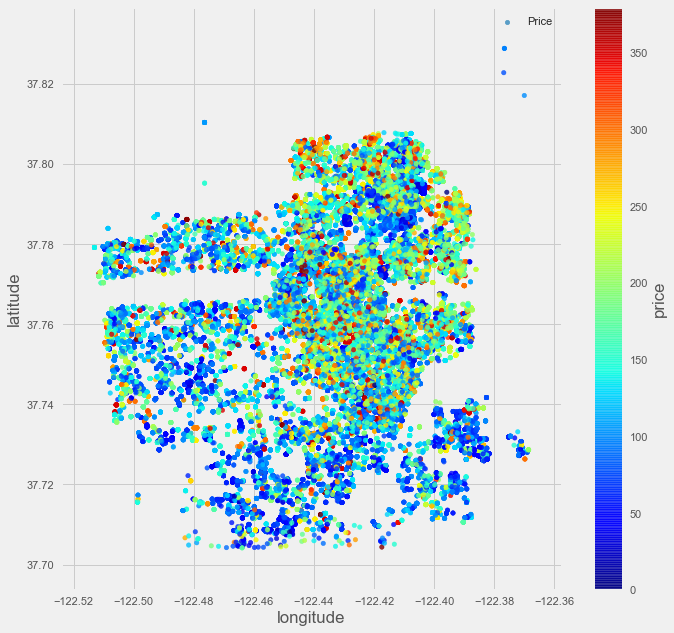

In [117]:
listings.plot(kind='scatter', x="longitude", y="latitude",c='price', 
          cmap=plt.get_cmap("jet"),label = 'Price', 
    colorbar=True, alpha=0.8, figsize=(10,10))
plt.legend()
plt.show()


**Heat map**

In [ ]:
corr = listings.corr()
plt.figure(figsize=(15, 15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,linewidths=.1,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Zillow

In [ ]:
zillow.set_index(keys = 'Date', inplace=True)

In [ ]:
zillow.head()

In [ ]:
zillow.shape

# Time Series Analysis

For this analysis, we will isolate the rows in our Zillow data that are in the zipcode or city of the listings data.

In [ ]:
#Capture zip information from listings
listings_zip = list(listings.zipcode.unique())

#Capture city information from listings 
listings_cities = list(listings.city.unique())

#Capture SF Data
sf_zillow = zillow[zillow['Zip'].isin(listings_zip) | zillow['City'].isin(listings_cities)]

#Check
print(sf_zillow.shape)
display(sf_zillow.tail())

In [ ]:
#SF vs rest of US Rent

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize = (12,5))
sf_zillow.groupby('Date')['Median_Rent'].mean().plot(kind = 'line')

zillow.loc['2011-09-01':'2019-11-01'].groupby(['Date'])['Median_Rent'].mean().plot(x_compat=True, kind = 'line', color= 'g')#green


#We also noted each state's region size ranking, which represents how big it is population-wise;
#California is ranked No. 1 with the largest population of all states, while Wyoming is ranked No. 51
zillow[zillow.SizeRank < 10].loc['2011-09-01':'2019-11-01'].groupby(['Date'])['Median_Rent'].mean().plot(x_compat=True, kind = 'line')

Airbnb monthly rent vs bay area rent 

In [ ]:
#Montly price
to_merge = listings[['id','monthly_price']]

calendar_dd = dd.from_pandas(calendar, npartitions=3)

test = calendar_dd.merge(to_merge, left_on='listing_id', right_on='id')

In [ ]:
#Drop useless columns
test = test.drop(columns =['id'] )
#set date as index

In [ ]:
test_pd = test[test.date < '2019-12-01'].compute()

In [ ]:
test_pd=test_pd[-test_pd.monthly_price.isna()]

test_pd.drop_duplicates(inplace = True)

In [ ]:
#Convert date to month-year format

#test_pd['date'] = pd.to_datetime(test_pd['date']).dt.to_period('M')

In [ ]:
test_pd.set_index('date', inplace=True)

In [ ]:
test_pd.sort_index(inplace=True)

In [ ]:
test_pd['Year'] = test_pd.index.year
test_pd['Month'] = test_pd.index.month
test_pd['Weekday Name'] = test_pd.index.weekday_name

In [ ]:
test_pd.head()

In [ ]:
test_pd.loc['2018-09':'2019-12'].groupby('date')['monthly_price'].mean().plot()

In [ ]:
sf_zillow.loc['2018-09':'2019-12'].groupby(['Date'])['Median_Rent'].mean().plot(kind = 'line')

In [ ]:
#test_pd.loc['2018-09':'2019-12'].groupby('date')['monthly_price'].mean().plot(kind = 'box')
sns.boxplot(x='Month', y = 'monthly_price', data = test_pd)

In [ ]:
sf_zillow.tail()

In [ ]:
calendar.head()

* Comparing monthly rent of airbnb to zillow

In [ ]:
listings.head(2)

In [ ]:
#test = sf_zillow.groupby(['Bedrooms', 'Date'])['Median_Rent'].mean().reset_index()
fig, ax = plt.subplots(figsize=(10,5))

sf_zillow.groupby("Bedrooms")['Median_Rent'].plot(kind="line", ax=ax)
plt.legend(title='Bedrooms', frameon = True, loc='upper right', labels=['studio', 'single','two','three'])


# Other variables and relationships worth exploring

### Principal Component Analysis